# Initialisation

## Environnement, bibliothèques, local settings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

# -- OS
import os
from google.colab import drive
import shutil
import zipfile

# -- Modeling
!pip install torch
!pip install torchvision
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torchvision import models
from torchvision.models import MobileNet_V2_Weights
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from sklearn.metrics import f1_score

# -- Divers
from tqdm import tqdm
import time


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# ---- Chemins d'accès
RootPath = ''

drive.mount('/content/drive')                                               # Je monte mon drive
RootPath = '/content/drive/MyDrive/Formation/Projet/Colab Notebooks/dbd/'   # Root
RootColabPath = '/content/'

ImgArcFullSrcPath = '/content/drive/MyDrive/Formation/Projet/images.zip'
ImgArcFullDstPath = '/content/images.zip'
ImgTrainPath = RootColabPath + 'images/image_train/'
ImgTestPath = RootColabPath + 'images/image_test/'

Mounted at /content/drive


## Design Images FS

In [ ]:
def prepare_data_structure(root_path, df, num_classes=27, img_height=500, img_width=500):
    '''
        Prépare la structure filesystem pour optimiser l'exploitation des images par le modèle

        Arg df contient le nom de chaque fichier et sa classe d'appartenance
        Retourne le chemin des dossiers train et validation et le mapping des classes
    '''

    images_path = os.path.join(root_path, 'images')
    train_dir = os.path.join(images_path, 'image_train_categorized')
    val_dir = os.path.join(images_path, 'image_validation_categorized')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    le = LabelEncoder()
    df['label'] = le.fit_transform(df['prdtypcode'])

    # Sauvegarde du mapping des classes
    classe_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    pd.Series(classe_mapping).to_csv(os.path.join(root_path, 'classe_mapping.csv'))

    # Séparation train/validation
    train_df, val_df = train_test_split(
        df,
        test_size=0.2,
        stratify=df['label'],
        random_state=42
    )

    # Fonction pour copie des images dans la structure
    def copy_images_to_categories(dataframe, destination_dir):
        for classe in dataframe['prdtypcode'].unique():
            classe_dir = os.path.join(destination_dir, classe)
            os.makedirs(classe_dir, exist_ok=True)

            classe_images = dataframe[dataframe['prdtypcode'] == classe]
            for _, row in classe_images.iterrows():
                src_path = os.path.join(images_path, 'image_train', row['filename'])
                dst_path = os.path.join(classe_dir, row['filename'])

                if os.path.exists(src_path):
                    shutil.copy(src_path, dst_path)

    # Copie des images pour train et validation
    copy_images_to_categories(train_df, train_dir)
    copy_images_to_categories(val_df, val_dir)

    print(f"Structure données créée :")
    print(f"- Train : {len(train_df)} images")
    print(f"- Validation : {len(val_df)} images")
    print(f"- Catégories : {len(classe_mapping)}")

    return train_dir, val_dir, classe_mapping

# Pour optimiser l'exploitation des fichiers images, il faut les importer préalablement dans le stockage local de Google Colab
shutil.copy(ImgArcFullSrcPath, RootColabPath)
with zipfile.ZipFile(ImgArcFullDstPath, 'r') as zipf:
  zipf.extractall(RootColabPath)

os.remove(ImgArcFullDstPath)
print(len(os.listdir(ImgTrainPath)))

# Prépare le set en constituant le nom de chaque fichier
df = pd.read_csv(RootPath + 'BestML1_set_clean.csv').fillna('')
df['filename'] = df.apply(lambda x: 'image_' + str(x['imageid']) + '_product_' + str(x['productid']) + '.jpg', axis=1)
df['prdtypcode'] = df['prdtypecode'].astype(str)
df = df[['filename', 'prdtypcode']].copy()

train_dir, val_dir, classe_mapping = prepare_data_structure(RootColabPath, df)

84916
Structure données créée :
- Train : 52014 images
- Validation : 13004 images
- Catégories : 27


### ResNet50_Weights

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import ResNet50_Weights
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, f1_score
import matplotlib.pyplot as plt
import os
import json

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Transformations avec augmentation de données
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Charger les données
print("Chargement des datasets...")
dataset_train = datasets.ImageFolder(root=train_dir, transform=transform_train)
dataset_val = datasets.ImageFolder(root=val_dir, transform=transform_val)

# DataLoaders
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Vérifier les classes
class_names = dataset_train.classes
num_classes = len(class_names)
print(f"Nombre de classes: {num_classes}")

# Utiliser GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de {device}")

bak_folder = '/content/drive/MyDrive/Formation/Projet/Colab Notebooks/dbd/checkpoints'

def create_model():
    """Fonction pour créer et configurer le modèle"""
    print("Initialisation du modèle ResNet50...")
    # Charger ResNet50 pré-entraîné
    weights = ResNet50_Weights.DEFAULT
    model = models.resnet50(weights=weights)

    # Stratégie de gel des couches
    for name, param in model.named_parameters():
        if "layer3" not in name and "layer4" not in name and "fc" not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    # Remplacer la couche fully connected
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.fc.in_features, num_classes)
    )

    return model, weights

def load_checkpoint(checkpoint_path, model=None, optimizer=None):
    """Charge un checkpoint sauvegardé"""
    print(f"Chargement du checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)

    # Si le modèle n'est pas fourni, le créer
    if model is None:
        model, weights = create_model()
        model.to(device)

    model.load_state_dict(checkpoint['model_state_dict'])

    # Si l'optimiseur n'est pas fourni, le créer
    if optimizer is None:
        optimizer = optim.Adam([
            {'params': [p for n, p in model.named_parameters() if "layer3" in n], 'lr': 1e-4},
            {'params': [p for n, p in model.named_parameters() if "layer4" in n], 'lr': 5e-4},
            {'params': model.fc.parameters(), 'lr': 1e-3}
        ])

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Charger l'historique d'entraînement s'il existe
    history = checkpoint.get('history', {'train_loss': [], 'val_loss': [], 'train_f1': [], 'val_f1': []})

    return model, optimizer, checkpoint['epoch'], checkpoint['best_val_f1'], checkpoint['counter'], history, checkpoint['scheduler_state_dict']

def save_checkpoint(epoch, model, optimizer, scheduler, best_val_f1, counter, history):
    """Sauvegarde l'état actuel de l'entraînement"""
    checkpoint_path = os.path.join(checkpoint_dir, f"resnet50_checkpoint_epoch_{epoch+1}.pth")
    print(f"Sauvegarde du checkpoint: {checkpoint_path}")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_f1': best_val_f1,
        'counter': counter,
        'history': history
    }, checkpoint_path)

    # Sauvegarder également l'historique en JSON pour faciliter la visualisation
    with open(os.path.join(checkpoint_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)

    shutil.copy(checkpoint_path, bak_folder)
    shutil.copy(os.path.join(checkpoint_dir, 'training_history.json'), bak_folder)

def evaluate(dataloader, model, criterion):
    """Évalue le modèle sur un ensemble de données"""
    model.eval()
    loss_total = 0
    predictions, true_vals = [], []

    with torch.no_grad():
        for batch in dataloader:
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss_total += loss.item()

            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_vals.extend(y_batch.cpu().numpy())

    avg_loss = loss_total / len(dataloader)
    f1score = f1_score(true_vals, predictions, average='weighted')
    return avg_loss, f1score

def train_model(start_epoch=0, total_epochs=15, best_val_f1=0, counter=0, history=None):
    """Fonction d'entraînement avec reprise possible"""
    # Créer ou charger le modèle
    if start_epoch == 0:
        model, weights = create_model()
        model.to(device)

        # Définir l'optimizer
        optimizer = optim.Adam([
            {'params': [p for n, p in model.named_parameters() if "layer3" in n], 'lr': 1e-4},
            {'params': [p for n, p in model.named_parameters() if "layer4" in n], 'lr': 5e-4},
            {'params': model.fc.parameters(), 'lr': 1e-3}
        ])

        # Initialiser l'historique
        if history is None:
            history = {'train_loss': [], 'val_loss': [], 'train_f1': [], 'val_f1': []}

        # Scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    else:
        # Retrouver le dernier checkpoint
        latest_checkpoint = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('resnet50_checkpoint')])[-1]
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
        model, optimizer, start_epoch, best_val_f1, counter, history, scheduler_state = load_checkpoint(checkpoint_path)

        # Recréer le scheduler et charger son état
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        scheduler.load_state_dict(scheduler_state)

    # Critère de perte
    criterion = nn.CrossEntropyLoss()

    # Paramètres pour early stopping
    patience = 5

    print(f"Démarrage de l'entraînement à l'époque {start_epoch+1}/{total_epochs}")

    for epoch in range(start_epoch, total_epochs):
        # Mode entraînement
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_predictions, train_true_vals = [], []

        progress_bar = tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{total_epochs}")

        for batch_idx, (X_batch, y_batch) in enumerate(progress_bar):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Réinitialiser les gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass et optimisation
            loss.backward()

            # Clip gradients pour éviter explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Statistiques
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += y_batch.size(0)
            train_correct += (predicted == y_batch).sum().item()
            train_predictions.extend(predicted.cpu().numpy())
            train_true_vals.extend(y_batch.cpu().numpy())

            progress_bar.set_postfix(
                {'training_loss': f"{train_loss/(batch_idx+1):.3f}",
                 'accuracy': f"{100*train_correct/train_total:.2f}%"}
            )

        # Calculer la précision d'entraînement
        train_f1 = f1_score(train_true_vals, train_predictions, average='weighted')
        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(dataloader_train)

        # Évaluation
        val_loss, val_f1 = evaluate(dataloader_val, model, criterion)

        # Mettre à jour le scheduler
        scheduler.step()

        # Enregistrer les métriques
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        print(f"Epoch {epoch+1}/{total_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train f1: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val f1: {val_f1:.4f}")

        # Sauvegarder le checkpoint de fin d'époque et backup sur mon drive
        save_checkpoint(epoch, model, optimizer, scheduler, best_val_f1, counter, history)

        # Sauvegarder le meilleur modèle
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_path = os.path.join(checkpoint_dir, 'best_resnet50_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'f1': val_f1
            }, best_model_path)
            shutil.copy('/content/checkpoints/best_resnet50_model.pth', bak_folder)
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping à l'époque {epoch+1}")
                break

    return model, history, best_val_f1

def check_for_existing_training():
    """Vérifie s'il existe déjà un entraînement en cours"""
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith('resnet50_checkpoint')]
    if not checkpoints:
        return 0, 15, 0, 0, None  # start_epoch, total_epochs, best_val_f1, counter, history

    # Trouver le checkpoint le plus récent
    latest_checkpoint = sorted(checkpoints)[-1]
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)

    checkpoint = torch.load(checkpoint_path)
    start_epoch = checkpoint['epoch'] + 1  # Reprendre à l'époque suivante
    best_val_f1 = checkpoint['best_val_f1']
    counter = checkpoint['counter']
    history = checkpoint.get('history', {'train_loss': [], 'val_loss': [], 'train_f1': [], 'val_f1': []})

    return start_epoch, 15, best_val_f1, counter, history

# Point d'entrée principal
if __name__ == "__main__":
    # Vérifier s'il existe déjà un entraînement en cours
    start_epoch, total_epochs, best_val_f1, counter, history = check_for_existing_training()

    # Demander à l'utilisateur s'il veut reprendre l'entraînement ou recommencer
    if start_epoch > 0:
        print(f"Un entraînement précédent existe (époque {start_epoch}/{total_epochs}).")
        choice = input("Voulez-vous reprendre l'entraînement? (o/n): ")
        if choice.lower() not in ['o', 'oui', 'y', 'yes']:
            start_epoch = 0
            best_val_f1 = 0
            counter = 0
            history = None

    # Lancer l'entraînement
    model, history, best_val_f1 = train_model(
        start_epoch=start_epoch,
        total_epochs=total_epochs,
        best_val_f1=best_val_f1,
        counter=counter,
        history=history
    )

    # Charger le meilleur modèle pour l'évaluation finale
    best_model_path = os.path.join(checkpoint_dir, 'best_resnet50_model.pth')
    model, _, _, _, _, _, _ = load_checkpoint(best_model_path)

    # Évaluation finale
    criterion = nn.CrossEntropyLoss()
    final_val_loss, final_val_f1 = evaluate(dataloader_val, model, criterion)
    print(f"f1-score finale: {final_val_f1:.4f}")
    print(f"Loss finale: {final_val_loss:.4f}")

    # Visualiser l'évolution de l'entraînement
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train f1-score')
    plt.plot(history['val_acc'], label='Val f1-score')
    plt.xlabel('Epoch')
    plt.ylabel('f1-score pondéré')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(checkpoint_dir, 'resnet50_training_history.png'))
    plt.show()

    # Classification report détaillé
    from sklearn.metrics import classification_report

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_val, y_val in dataloader_val:
            X_val = X_val.to(device)
            outputs = model(X_val)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_val.numpy())

    print("\nRapport de classification détaillé:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

Chargement des datasets...
Nombre de classes: 27


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Utilisation de cuda
Initialisation du modèle ResNet50...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 98.5MB/s]


Démarrage de l'entraînement à l'époque 1/15


Epoch 1/15: 100%|██████████| 1626/1626 [07:18<00:00,  3.71it/s, training_loss=1.712, accuracy=49.80%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/15
  Train Loss: 1.7121, Train f1: 0.4765
  Val Loss: 1.2758, Val f1: 0.6078
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_1.pth


Epoch 2/15:   0%|          | 0/1626 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/15: 100%|██████████| 1626/1626 [07:17<00:00,  3.72it/s, training_loss=1.420, accuracy=57.57%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to

Epoch 2/15
  Train Loss: 1.4203, Train f1: 0.5620
  Val Loss: 1.2000, Val f1: 0.6333
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_2.pth


Epoch 3/15:   0%|          | 0/1626 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3/15: 100%|██████████| 1626/1626 [07:12<00:00,  3.76it/s, training_loss=1.285, accuracy=60.84%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to

Epoch 3/15
  Train Loss: 1.2854, Train f1: 0.5983
  Val Loss: 1.1317, Val f1: 0.6570
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_3.pth


Epoch 4/15:   0%|          | 0/1626 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/15: 100%|██████████| 1626/1626 [07:24<00:00,  3.66it/s, training_loss=1.171, accuracy=64.01%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to

Epoch 4/15
  Train Loss: 1.1714, Train f1: 0.6320
  Val Loss: 1.1161, Val f1: 0.6649
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_4.pth


Epoch 5/15:   0%|          | 0/1626 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/15: 100%|██████████| 1626/1626 [07:30<00:00,  3.61it/s, training_loss=1.073, accuracy=66.58%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to

Epoch 5/15
  Train Loss: 1.0730, Train f1: 0.6589
  Val Loss: 1.0779, Val f1: 0.6806
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_5.pth


Epoch 6/15:   0%|          | 0/1626 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6/15: 100%|██████████| 1626/1626 [07:23<00:00,  3.67it/s, training_loss=0.972, accuracy=69.64%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to

Epoch 6/15
  Train Loss: 0.9715, Train f1: 0.6909
  Val Loss: 1.0784, Val f1: 0.6854
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_6.pth


Epoch 7/15:   0%|          | 0/1626 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/15: 100%|██████████| 1626/1626 [07:21<00:00,  3.68it/s, training_loss=0.880, accuracy=72.31%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to

Epoch 7/15
  Train Loss: 0.8798, Train f1: 0.7187
  Val Loss: 1.0732, Val f1: 0.6886
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_7.pth


Epoch 8/15:   0%|          | 0/1626 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8/15: 100%|██████████| 1626/1626 [07:19<00:00,  3.70it/s, training_loss=0.801, accuracy=74.65%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to

Epoch 8/15
  Train Loss: 0.8008, Train f1: 0.7426
  Val Loss: 1.0875, Val f1: 0.6970
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_8.pth


Epoch 9/15:   0%|          | 0/1626 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9/15: 100%|██████████| 1626/1626 [07:17<00:00,  3.71it/s, training_loss=0.728, accuracy=76.68%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to

Epoch 9/15
  Train Loss: 0.7284, Train f1: 0.7639
  Val Loss: 1.1051, Val f1: 0.6989
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_9.pth


Epoch 10/15:   0%|          | 0/1626 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/15: 100%|██████████| 1626/1626 [07:17<00:00,  3.72it/s, training_loss=0.702, accuracy=77.50%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number 

Epoch 10/15
  Train Loss: 0.7016, Train f1: 0.7723
  Val Loss: 1.1165, Val f1: 0.6993
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_10.pth


Epoch 11/15:   0%|          | 0/1626 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11/15: 100%|██████████| 1626/1626 [07:13<00:00,  3.75it/s, training_loss=0.697, accuracy=77.54%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number 

Epoch 11/15
  Train Loss: 0.6967, Train f1: 0.7726
  Val Loss: 1.1104, Val f1: 0.6987
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_11.pth


Epoch 12/15:   0%|          | 0/1626 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12/15: 100%|██████████| 1626/1626 [07:18<00:00,  3.71it/s, training_loss=0.688, accuracy=77.99%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number 

Epoch 12/15
  Train Loss: 0.6879, Train f1: 0.7774
  Val Loss: 1.1136, Val f1: 0.6997
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_12.pth


Epoch 13/15:   0%|          | 0/1626 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13/15: 100%|██████████| 1626/1626 [07:20<00:00,  3.69it/s, training_loss=0.696, accuracy=77.59%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number 

Epoch 13/15
  Train Loss: 0.6963, Train f1: 0.7733
  Val Loss: 1.1275, Val f1: 0.6964
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_13.pth


Epoch 14/15:   0%|          | 0/1626 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 14/15: 100%|██████████| 1626/1626 [07:15<00:00,  3.73it/s, training_loss=0.707, accuracy=77.14%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number 

Epoch 14/15
  Train Loss: 0.7073, Train f1: 0.7685
  Val Loss: 1.1408, Val f1: 0.6942
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_14.pth


Epoch 15/15:   0%|          | 0/1626 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 15/15: 100%|██████████| 1626/1626 [07:20<00:00,  3.69it/s, training_loss=0.726, accuracy=76.66%]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number 

Epoch 15/15
  Train Loss: 0.7257, Train f1: 0.7639
  Val Loss: 1.1355, Val f1: 0.6890
Sauvegarde du checkpoint: checkpoints/resnet50_checkpoint_epoch_15.pth
Chargement du checkpoint: checkpoints/best_resnet50_model.pth
Initialisation du modèle ResNet50...


KeyError: 'best_val_f1'

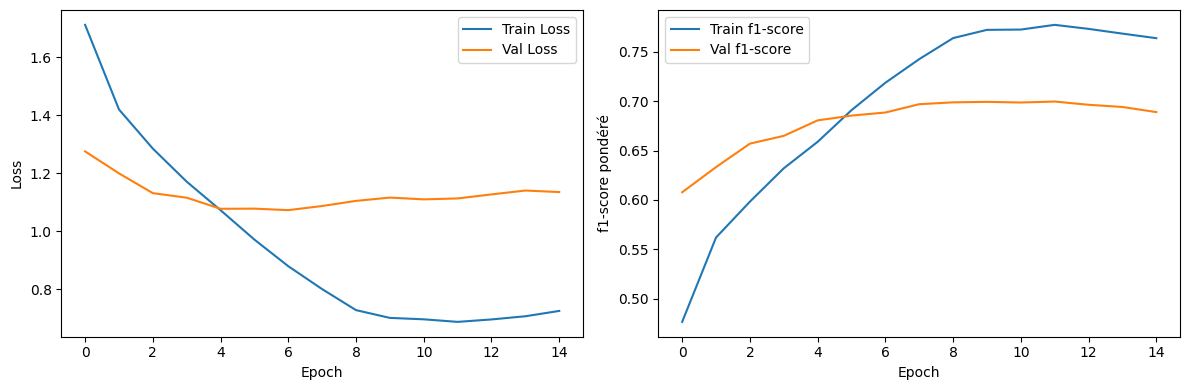

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_f1'], label='Train f1-score')
plt.plot(history['val_f1'], label='Val f1-score')
plt.xlabel('Epoch')
plt.ylabel('f1-score pondéré')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(checkpoint_dir, 'resnet50_training_history.png'))
plt.show()
